# Train a fully connected (dense) neural network for EMNIST Digits

In [1]:
using Flux
using Statistics
using MLDatasets
using DataFrames
using OneHotArrays
using CairoMakie
using ProgressBars

## MNIST dataset

In [2]:
data = MNIST(split = :train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

### Data Exploration and Visualisation

In [3]:
test_data = MNIST(split = :test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [4]:
data.features[:, :, 1]

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  

In [5]:
data.targets[1]

5

In [6]:
"""
    pos(v, cols)

Map an integer value to a [row, col] position in a grid of `cols` columns.
"""
function pos(v, cols)
    return mod1(v, cols), div(v - 1, cols) + 1
end;

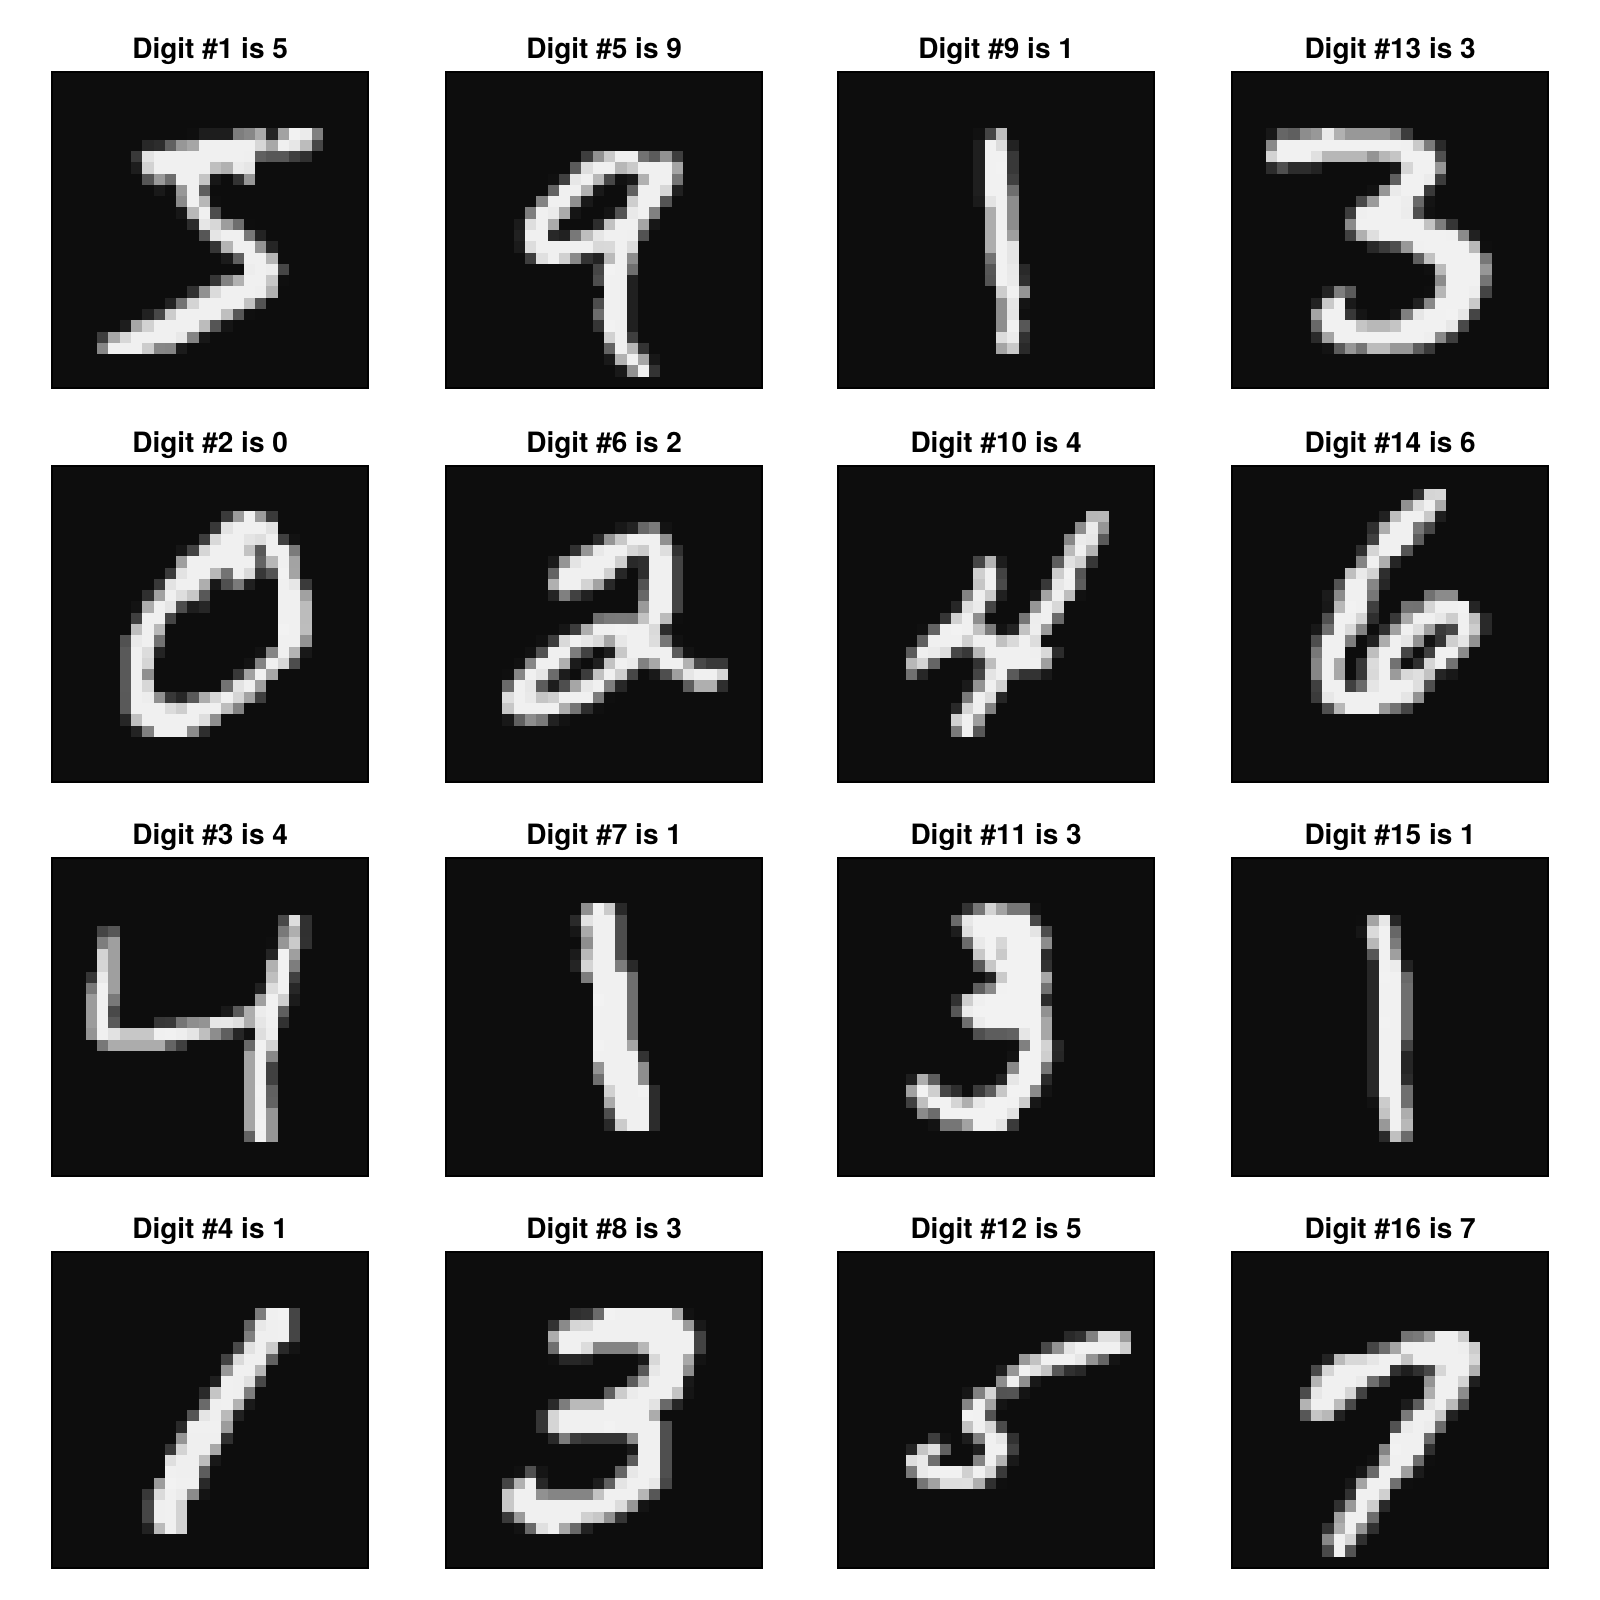

In [7]:
# Now plot a bunch of the first digits
#
# Note that the orientation is with the lowest row at the bottom of the visualisation,
# hence the `yreversed=true` in the Axis.
f = Figure(size=(800,800))
for d in 1:16
    ax = Axis(f[pos(d,4)...], aspect = DataAspect(), yreversed=true,
        title = "Digit #$d is $(Int(data.targets[d]))",)
    hidedecorations!(ax)
    heatmap!(ax, data.features[:, :, d], 
        colormap = :grays,
    )
end
f

## Network Definition

We define a network that takes the 28x28 input image array (vector of 784), passes it through two hidden layers of 1000 neurons, then the output layer is 10 neurons, passed through softmax.

In [8]:
dense_model = Chain(
    Dense(28 * 28, 1000, relu),
    Dense(1000, 1000, relu),
    Dense(1000, 10),
    softmax
)

Chain(
  Dense(784 => 1000, relu),             # 785_000 parameters
  Dense(1000 => 1000, relu),            # 1_001_000 parameters
  Dense(1000 => 10),                    # 10_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 1_796_010 parameters, 6.852 MiB.

In [9]:
dense_model(reshape(data.features[:, :, 1], (784, 1)))

10×1 Matrix{Float32}:
 0.12952995
 0.08320278
 0.12048166
 0.093369685
 0.07385274
 0.101397134
 0.07715162
 0.098464996
 0.098279506
 0.124269895

In [10]:
const classes = sort(unique(data.targets))

10-element Vector{Int64}:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [11]:
flux_y_onehot = onehotbatch(data.targets, classes)
# test_y = onehotbatch(test_data.targets, classes);

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [12]:
test_y = onehotbatch(test_data.targets, classes)

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [13]:
flux_x = reshape(data.features, (28 * 28, size(data.features, 3)));
test_x = reshape(test_data.features, (28 * 28, size(test_data.features, 3)));

In [25]:
flux_data = [(flux_x, flux_y_onehot)];
test_dataset = [(test_x, test_y)];

In [26]:
function flux_loss(flux_model, features, labels_onehot)
    ŷ = flux_model(features)
    Flux.logitcrossentropy(ŷ, labels_onehot)
end;

In [27]:
flux_loss(dense_model, flux_x, flux_y_onehot)

1.4906328f0

In [28]:
flux_accuracy(x, y) = mean(Flux.onecold(dense_model(x), classes) .== y);

In [29]:
flux_accuracy(flux_x, data.targets)

0.9738

## Training Loops

In [30]:
# Manual training function
function train_flux_model!(f_loss, model, features, labels_onehot)
    dLdm, _, _ = gradient(f_loss, model, features, labels_onehot)
    @. model[1].weight = model[1].weight - 0.1 * dLdm[:layers][1][:weight]
    @. model[1].bias = model[1].bias - 0.1 * dLdm[:layers][1][:bias]
end;
# train_flux_model!(flux_loss, dense_model, flux_x, flux_y_onehot);

train_flux_model! (generic function with 1 method)

### Loop using `train!`

In [31]:
opt_state = Flux.setup(Adam(), dense_model);
# Flux.train!(dense_model, flux_data, opt_state) do m, x, y
#     flux_loss(m, x, y)
# end

(layers = ((weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 

In [21]:
# Now run for a decent number of epochs
epochs = 100
accuracy = Vector{Float32}()
test_accuracy = Vector{Float32}()
for i in ProgressBar(1:epochs)
    Flux.train!(dense_model, flux_data, opt_state) do m, x, y
        flux_loss(m, x, y)
    end
    acc = flux_accuracy(flux_x, data.targets)
    test_acc = flux_accuracy(test_x, test_data.targets)
    push!(accuracy, acc)
    push!(test_accuracy, test_acc)
    println("Accuracy after epoch $i: $acc (train), $test_acc (test)")
end


0.0%┣                                             ┫ 0/100 [00:02<-3:-53, -2s/it]

Accuracy after epoch 1: 0.5616833333333333 (train), 0.5713 (test)


Accuracy after epoch 2: 0.6277333333333334 (train), 0.6293 (test)


1.0%┣▍                                         ┫ 1/100 [00:15<Inf:Inf, InfGs/it]


Accuracy after epoch 3: 0.6662 (train), 0.6723 (test)


2.0%┣█                                             ┫ 2/100 [00:19<30:37, 19s/it]


Accuracy after epoch 4: 0.72185 (train), 0.7348 (test)


3.0%┣█▍                                            ┫ 3/100 [00:22<17:51, 11s/it]


Accuracy after epoch 5: 0.77295 (train), 0.7844 (test)


4.0%┣█▉                                             ┫ 4/100 [00:26<13:40, 9s/it]


Accuracy after epoch 6: 0.78335 (train), 0.7955 (test)


5.0%┣██▍                                            ┫ 5/100 [00:29<11:32, 7s/it]


Accuracy after epoch 7: 0.7854 (train), 0.7921 (test)


6.0%┣██▉                                            ┫ 6/100 [00:33<10:20, 7s/it]


Accuracy after epoch 8: 0.7998 (train), 0.8089 (test)


7.0%┣███▎                                           ┫ 7/100 [00:37<09:29, 6s/it]


Accuracy after epoch 9: 0.82105 (train), 0.8273 (test)


8.0%┣███▊                                           ┫ 8/100 [00:41<08:52, 6s/it]


Accuracy after epoch 10: 0.86235 (train), 0.875 (test)


9.0%┣████▎                                          ┫ 9/100 [00:44<08:19, 5s/it]


Accuracy after epoch 11: 0.8090333333333334 (train), 0.8155 (test)


10.0%┣████▌                                        ┫ 10/100 [00:48<07:56, 5s/it]


Accuracy after epoch 12: 0.8720666666666667 (train), 0.8759 (test)


11.0%┣█████                                        ┫ 11/100 [00:51<07:35, 5s/it]


Accuracy after epoch 13: 0.8523666666666667 (train), 0.8565 (test)


12.0%┣█████▍                                       ┫ 12/100 [00:55<07:17, 5s/it]


Accuracy after epoch 14: 0.8454 (train), 0.848 (test)


13.0%┣█████▉                                       ┫ 13/100 [00:58<07:01, 5s/it]


Accuracy after epoch 15: 0.8531333333333333 (train), 0.8566 (test)


14.0%┣██████▎                                      ┫ 14/100 [01:02<06:51, 5s/it]


Accuracy after epoch 16: 0.873 (train), 0.8767 (test)


15.0%┣██████▊                                      ┫ 15/100 [01:06<06:40, 5s/it]


Accuracy after epoch 17: 0.89605 (train), 0.8997 (test)


16.0%┣███████▏                                     ┫ 16/100 [01:10<06:31, 5s/it]


Accuracy after epoch 18: 0.8926666666666667 (train), 0.8993 (test)


17.0%┣███████▋                                     ┫ 17/100 [01:14<06:23, 5s/it]


Accuracy after epoch 19: 0.88445 (train), 0.8909 (test)


18.0%┣████████                                     ┫ 18/100 [01:17<06:14, 5s/it]


Accuracy after epoch 20: 0.9019666666666667 (train), 0.9068 (test)


19.0%┣████████▌                                    ┫ 19/100 [01:21<06:03, 4s/it]


Accuracy after epoch 21: 0.9069166666666667 (train), 0.9088 (test)


20.0%┣█████████                                    ┫ 20/100 [01:25<05:56, 4s/it]


Accuracy after epoch 22: 0.9035666666666666 (train), 0.9048 (test)


21.0%┣█████████▌                                   ┫ 21/100 [01:28<05:48, 4s/it]


Accuracy after epoch 23: 0.9028166666666667 (train), 0.9028 (test)


22.0%┣██████████                                   ┫ 22/100 [01:31<05:40, 4s/it]


Accuracy after epoch 24: 0.9065333333333333 (train), 0.9068 (test)


23.0%┣██████████▍                                  ┫ 23/100 [01:35<05:32, 4s/it]


Accuracy after epoch 25: 0.91175 (train), 0.9132 (test)


24.0%┣██████████▉                                  ┫ 24/100 [01:38<05:24, 4s/it]


Accuracy after epoch 26: 0.9155166666666666 (train), 0.9168 (test)


25.0%┣███████████▎                                 ┫ 25/100 [01:41<05:17, 4s/it]


Accuracy after epoch 27: 0.9162666666666667 (train), 0.917 (test)


26.0%┣███████████▊                                 ┫ 26/100 [01:45<05:10, 4s/it]


Accuracy after epoch 28: 0.9178166666666666 (train), 0.9198 (test)


27.0%┣████████████▏                                ┫ 27/100 [01:49<05:05, 4s/it]


Accuracy after epoch 29: 0.9198833333333334 (train), 0.9224 (test)


28.0%┣████████████▋                                ┫ 28/100 [01:52<04:58, 4s/it]


Accuracy after epoch 30: 0.9229833333333334 (train), 0.9238 (test)


29.0%┣█████████████                                ┫ 29/100 [01:55<04:52, 4s/it]


Accuracy after epoch 31: 0.9244333333333333 (train), 0.9244 (test)


30.0%┣█████████████▌                               ┫ 30/100 [01:59<04:46, 4s/it]


Accuracy after epoch 32: 0.9259666666666667 (train), 0.924 (test)


31.0%┣██████████████                               ┫ 31/100 [02:02<04:41, 4s/it]


Accuracy after epoch 33: 0.9284333333333333 (train), 0.9268 (test)


32.0%┣██████████████▍                              ┫ 32/100 [02:06<04:36, 4s/it]


Accuracy after epoch 34: 0.9294333333333333 (train), 0.9278 (test)


33.0%┣██████████████▉                              ┫ 33/100 [02:09<04:30, 4s/it]


Accuracy after epoch 35: 0.9292333333333334 (train), 0.9278 (test)


34.0%┣███████████████▎                             ┫ 34/100 [02:13<04:26, 4s/it]


Accuracy after epoch 36: 0.9296833333333333 (train), 0.928 (test)


35.0%┣███████████████▊                             ┫ 35/100 [02:17<04:21, 4s/it]


Accuracy after epoch 37: 0.9314166666666667 (train), 0.9295 (test)


36.0%┣████████████████▏                            ┫ 36/100 [02:20<04:16, 4s/it]


Accuracy after epoch 38: 0.93365 (train), 0.9319 (test)


37.0%┣████████████████▋                            ┫ 37/100 [02:24<04:11, 4s/it]


Accuracy after epoch 39: 0.9356166666666667 (train), 0.9334 (test)


38.0%┣█████████████████                            ┫ 38/100 [02:27<04:06, 4s/it]


Accuracy after epoch 40: 0.9362333333333334 (train), 0.9337 (test)


39.0%┣█████████████████▌                           ┫ 39/100 [02:30<04:01, 4s/it]


Accuracy after epoch 41: 0.9370833333333334 (train), 0.9352 (test)


40.0%┣██████████████████                           ┫ 40/100 [02:33<03:56, 4s/it]


Accuracy after epoch 42: 0.93825 (train), 0.9371 (test)


41.0%┣██████████████████▌                          ┫ 41/100 [02:37<03:51, 4s/it]


Accuracy after epoch 43: 0.9392666666666667 (train), 0.938 (test)


42.0%┣███████████████████                          ┫ 42/100 [02:40<03:47, 4s/it]


Accuracy after epoch 44: 0.9404666666666667 (train), 0.9387 (test)


43.0%┣███████████████████▍                         ┫ 43/100 [02:44<03:42, 4s/it]


Accuracy after epoch 45: 0.9417166666666666 (train), 0.9397 (test)


44.0%┣███████████████████▉                         ┫ 44/100 [02:47<03:38, 4s/it]


Accuracy after epoch 46: 0.9424 (train), 0.9402 (test)


45.0%┣████████████████████▎                        ┫ 45/100 [02:51<03:33, 4s/it]


Accuracy after epoch 47: 0.94365 (train), 0.9401 (test)


46.0%┣████████████████████▊                        ┫ 46/100 [02:54<03:29, 4s/it]


Accuracy after epoch 48: 0.9445833333333333 (train), 0.9412 (test)


47.0%┣█████████████████████▏                       ┫ 47/100 [02:57<03:24, 4s/it]


Accuracy after epoch 49: 0.9453833333333334 (train), 0.9415 (test)


48.0%┣█████████████████████▋                       ┫ 48/100 [03:01<03:20, 4s/it]


Accuracy after epoch 50: 0.94645 (train), 0.9421 (test)


49.0%┣██████████████████████                       ┫ 49/100 [03:04<03:16, 4s/it]


Accuracy after epoch 51: 0.9472833333333334 (train), 0.9432 (test)


50.0%┣██████████████████████▌                      ┫ 50/100 [03:07<03:11, 4s/it]


Accuracy after epoch 52: 0.9480833333333333 (train), 0.9438 (test)


51.0%┣███████████████████████                      ┫ 51/100 [03:11<03:07, 4s/it]


Accuracy after epoch 53: 0.9491833333333334 (train), 0.9453 (test)


52.0%┣███████████████████████▍                     ┫ 52/100 [03:14<03:03, 4s/it]


Accuracy after epoch 54: 0.9499833333333333 (train), 0.9458 (test)


53.0%┣███████████████████████▉                     ┫ 53/100 [03:18<02:59, 4s/it]


Accuracy after epoch 55: 0.9506666666666667 (train), 0.9472 (test)


54.0%┣████████████████████████▎                    ┫ 54/100 [03:21<02:55, 4s/it]


Accuracy after epoch 56: 0.9515666666666667 (train), 0.9474 (test)


55.0%┣████████████████████████▊                    ┫ 55/100 [03:25<02:51, 4s/it]


Accuracy after epoch 57: 0.9522166666666667 (train), 0.9481 (test)


56.0%┣█████████████████████████▏                   ┫ 56/100 [03:28<02:46, 4s/it]


Accuracy after epoch 58: 0.9529833333333333 (train), 0.9487 (test)


57.0%┣█████████████████████████▋                   ┫ 57/100 [03:31<02:42, 4s/it]


Accuracy after epoch 59: 0.9536666666666667 (train), 0.9494 (test)


58.0%┣██████████████████████████                   ┫ 58/100 [03:35<02:38, 4s/it]


Accuracy after epoch 60: 0.9545 (train), 0.9491 (test)


59.0%┣██████████████████████████▌                  ┫ 59/100 [03:38<02:34, 4s/it]


Accuracy after epoch 61: 0.9551833333333334 (train), 0.9496 (test)


60.0%┣███████████████████████████                  ┫ 60/100 [03:41<02:30, 4s/it]


Accuracy after epoch 62: 0.9558166666666666 (train), 0.9501 (test)


61.0%┣███████████████████████████▌                 ┫ 61/100 [03:45<02:26, 4s/it]


Accuracy after epoch 63: 0.9565166666666667 (train), 0.9508 (test)


62.0%┣████████████████████████████                 ┫ 62/100 [03:48<02:22, 4s/it]


Accuracy after epoch 64: 0.9572333333333334 (train), 0.951 (test)


63.0%┣████████████████████████████▍                ┫ 63/100 [03:52<02:18, 4s/it]


Accuracy after epoch 65: 0.9576833333333333 (train), 0.9508 (test)


64.0%┣████████████████████████████▉                ┫ 64/100 [03:55<02:14, 4s/it]


Accuracy after epoch 66: 0.9584166666666667 (train), 0.9515 (test)


65.0%┣█████████████████████████████▎               ┫ 65/100 [03:58<02:10, 4s/it]


Accuracy after epoch 67: 0.9592333333333334 (train), 0.952 (test)


66.0%┣█████████████████████████████▊               ┫ 66/100 [04:02<02:06, 4s/it]


Accuracy after epoch 68: 0.9599166666666666 (train), 0.9523 (test)


67.0%┣██████████████████████████████▏              ┫ 67/100 [04:05<02:03, 4s/it]


Accuracy after epoch 69: 0.9605 (train), 0.9529 (test)


68.0%┣██████████████████████████████▋              ┫ 68/100 [04:09<01:59, 4s/it]


Accuracy after epoch 70: 0.96115 (train), 0.9532 (test)


69.0%┣███████████████████████████████              ┫ 69/100 [04:12<01:55, 4s/it]


Accuracy after epoch 71: 0.9617833333333333 (train), 0.9536 (test)


70.0%┣███████████████████████████████▌             ┫ 70/100 [04:15<01:51, 4s/it]


Accuracy after epoch 72: 0.9623666666666667 (train), 0.9539 (test)


71.0%┣████████████████████████████████             ┫ 71/100 [04:18<01:47, 4s/it]


Accuracy after epoch 73: 0.96285 (train), 0.954 (test)


72.0%┣████████████████████████████████▍            ┫ 72/100 [04:22<01:43, 4s/it]


Accuracy after epoch 74: 0.9633666666666667 (train), 0.9542 (test)


73.0%┣████████████████████████████████▉            ┫ 73/100 [04:25<01:39, 4s/it]


Accuracy after epoch 75: 0.9640166666666666 (train), 0.9551 (test)


74.0%┣█████████████████████████████████▎           ┫ 74/100 [04:28<01:36, 4s/it]


Accuracy after epoch 76: 0.9646333333333333 (train), 0.9556 (test)


75.0%┣█████████████████████████████████▊           ┫ 75/100 [04:34<01:33, 4s/it]


Accuracy after epoch 77: 0.96515 (train), 0.9558 (test)


76.0%┣██████████████████████████████████▏          ┫ 76/100 [04:38<01:29, 4s/it]


Accuracy after epoch 78: 0.9653666666666667 (train), 0.9563 (test)


77.0%┣█████████████████████████████████▉          ┫ 77/100 [12:03<03:39, 10s/it]


Accuracy after epoch 79: 0.96595 (train), 0.9568 (test)


78.0%┣███████████████████████████████████          ┫ 78/100 [12:07<03:28, 9s/it]


Accuracy after epoch 80: 0.9665 (train), 0.9576 (test)


79.0%┣███████████████████████████████████▌         ┫ 79/100 [12:10<03:17, 9s/it]


Accuracy after epoch 81: 0.9668333333333333 (train), 0.9577 (test)


80.0%┣████████████████████████████████████         ┫ 80/100 [12:16<03:06, 9s/it]


Accuracy after epoch 82: 0.96735 (train), 0.9583 (test)


81.0%┣████████████████████████████████████▌        ┫ 81/100 [12:21<02:56, 9s/it]


Accuracy after epoch 83: 0.9677333333333333 (train), 0.9589 (test)


82.0%┣█████████████████████████████████████        ┫ 82/100 [12:24<02:45, 9s/it]


Accuracy after epoch 84: 0.96835 (train), 0.9591 (test)


83.0%┣█████████████████████████████████████▍       ┫ 83/100 [12:28<02:35, 9s/it]


Accuracy after epoch 85: 0.9687833333333333 (train), 0.9596 (test)


84.0%┣█████████████████████████████████████▉       ┫ 84/100 [12:32<02:25, 9s/it]


Accuracy after epoch 86: 0.9691333333333333 (train), 0.9599 (test)


85.0%┣██████████████████████████████████████▎      ┫ 85/100 [12:35<02:15, 9s/it]


Accuracy after epoch 87: 0.96955 (train), 0.9602 (test)


86.0%┣██████████████████████████████████████▊      ┫ 86/100 [12:38<02:05, 9s/it]


Accuracy after epoch 88: 0.9698333333333333 (train), 0.9606 (test)


87.0%┣███████████████████████████████████████▏     ┫ 87/100 [12:42<01:55, 9s/it]


Accuracy after epoch 89: 0.9700833333333333 (train), 0.9607 (test)


88.0%┣███████████████████████████████████████▋     ┫ 88/100 [12:46<01:46, 9s/it]


Accuracy after epoch 90: 0.9703666666666667 (train), 0.9612 (test)


89.0%┣████████████████████████████████████████     ┫ 89/100 [12:49<01:36, 9s/it]


Accuracy after epoch 91: 0.97075 (train), 0.9617 (test)


90.0%┣████████████████████████████████████████▌    ┫ 90/100 [12:53<01:27, 9s/it]


Accuracy after epoch 92: 0.9711833333333333 (train), 0.9618 (test)


91.0%┣█████████████████████████████████████████    ┫ 91/100 [12:56<01:18, 9s/it]


Accuracy after epoch 93: 0.9717166666666667 (train), 0.9621 (test)


92.0%┣█████████████████████████████████████████▍   ┫ 92/100 [12:59<01:09, 9s/it]


Accuracy after epoch 94: 0.9720333333333333 (train), 0.9625 (test)


93.0%┣█████████████████████████████████████████▉   ┫ 93/100 [13:03<01:00, 9s/it]


Accuracy after epoch 95: 0.9723 (train), 0.9627 (test)


94.0%┣██████████████████████████████████████████▎  ┫ 94/100 [13:06<00:51, 8s/it]


Accuracy after epoch 96: 0.9726333333333333 (train), 0.9629 (test)


95.0%┣██████████████████████████████████████████▊  ┫ 95/100 [13:09<00:42, 8s/it]


Accuracy after epoch 97: 0.9728666666666667 (train), 0.9633 (test)


96.0%┣███████████████████████████████████████████▏ ┫ 96/100 [13:13<00:33, 8s/it]


Accuracy after epoch 98: 0.9732333333333333 (train), 0.9637 (test)


97.0%┣███████████████████████████████████████████▋ ┫ 97/100 [13:16<00:25, 8s/it]


Accuracy after epoch 99: 0.9735666666666667 (train), 0.964 (test)


98.0%┣████████████████████████████████████████████ ┫ 98/100 [13:20<00:16, 8s/it]


Accuracy after epoch 100: 0.9738 (train), 0.9641 (test)


99.0%┣████████████████████████████████████████████▌┫ 99/100 [13:23<00:08, 8s/it]
100.0%┣███████████████████████████████████████████┫ 100/100 [13:26<00:00, 8s/it]
100.0%┣███████████████████████████████████████████┫ 100/100 [13:26<00:00, 8s/it]


In [22]:
flux_accuracy(test_x, test_data.targets)

0.9641

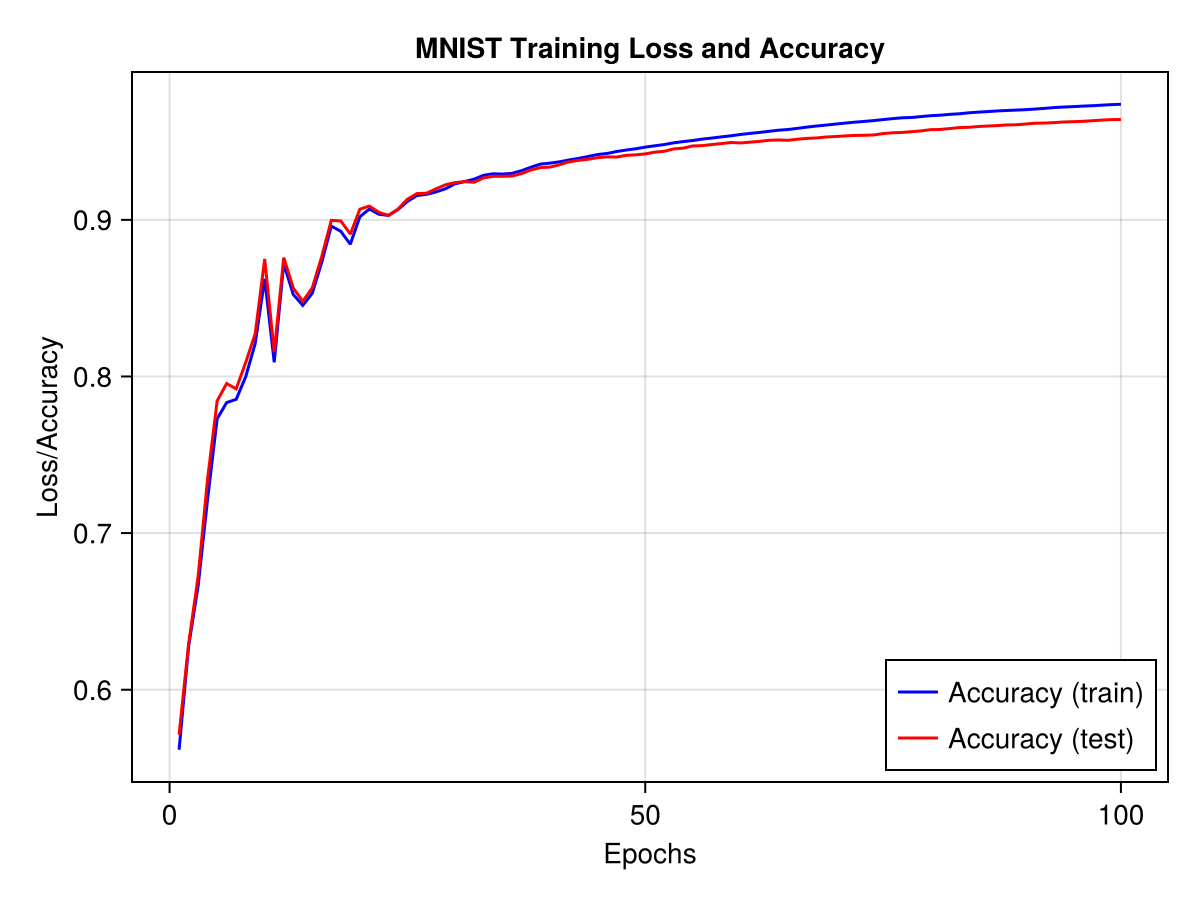

In [ ]:
let 
    f = Figure()
    ax = Axis(f[1, 1],
        title = "MNIST Training Loss and Accuracy",
        xlabel = "Epochs",
        ylabel = "Accuracy",)
    epochs = collect(1:length(accuracy))
    # lines!(ax, epochs, loss, label = "Loss", color = :red)
    lines!(ax, epochs, accuracy, label = "Accuracy (train)", color = :blue)
    lines!(ax, epochs, test_accuracy, label = "Accuracy (test)", color = :red)
    axislegend(position = :rb)
    f
end